<a href="https://colab.research.google.com/github/vinit6085903/anpr/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [2]:
import os
print(os.listdir(path) )

['Training', 'Testing']


In [3]:
import tensorflow as tf

img_size = (224, 224)
batch_size = 32

train_dir = path + "/Training"
test_dir  = path + "/Testing"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes:", train_data.class_names)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
import cv2
import os
import numpy as np

data = []
labels = []

categories = ["glioma", "meningioma", "notumor", "pituitary"]

for category in categories:
    folder = os.path.join(path, "Training", category)
    label = categories.index(category)

    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))

        data.append(img)
        labels.append(label)

X = np.array(data)
y = np.array(labels)

print(X.shape, y.shape)


(5712, 224, 224, 3) (5712,)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

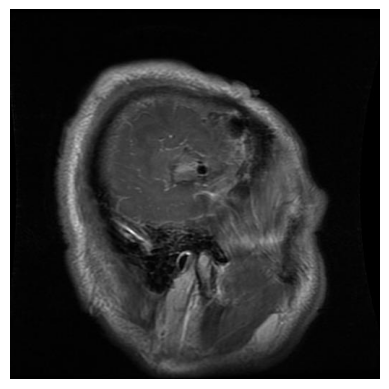

In [5]:
from matplotlib import pyplot as plt
import cv2
import os

folder = path + "/Training/glioma"
img = cv2.imread(os.path.join(folder, os.listdir(folder)[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


In [8]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False   # very important for CPU


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [10]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [23]:
history = model.fit(
    X, y,
    epochs=10,
    batch_size=16,
    validation_split=0.2
)


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.8957 - loss: 0.2692 - val_accuracy: 0.8416 - val_loss: 0.4339
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 331s 1s/step - accuracy: 0.9087 - loss: 0.2491 - val_accuracy: 0.8898 - val_loss: 0.3002
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 379s 1s/step - accuracy: 0.9069 - loss: 0.2382 - val_accuracy: 0.8976 - val_loss: 0.3000
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.9047 - loss: 0.2499 - val_accuracy: 0.8775 - val_loss: 0.3428
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9070 - loss: 0.2292 - val_accuracy: 0.8066 - val_loss: 0.5414
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.9115 - loss: 0.2347 - val_accuracy: 0.8836 - val_loss: 0.3191
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - accuracy: 0.9077 - loss: 0.2403 - val_accuracy: 0.9011 - val_loss: 0.2911
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.9146 - loss: 0.2278 - val_accu

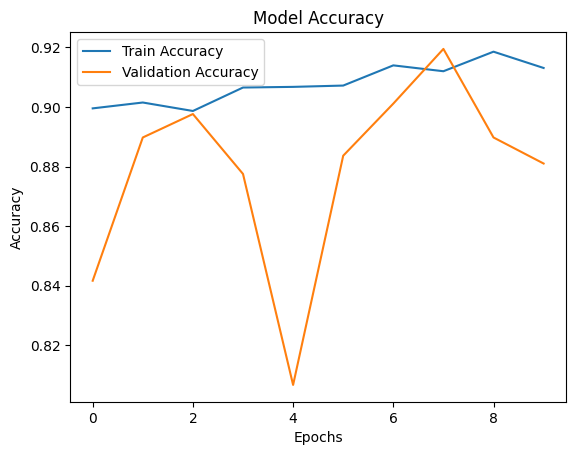

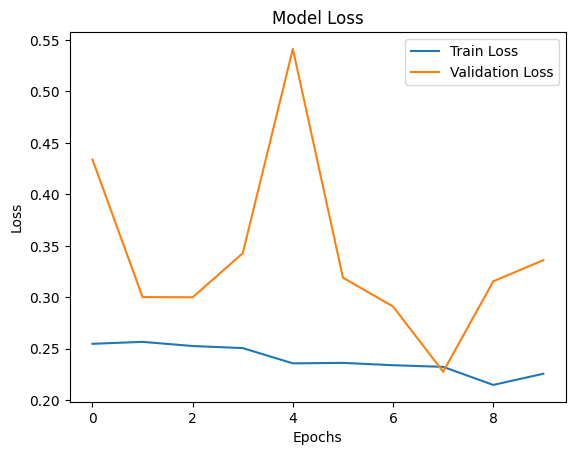

In [24]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.show()

# Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()


In [25]:
train_loss, train_acc = model.evaluate(X, y, verbose=0)
print("Train Accuracy:", train_acc)


Train Accuracy: 0.9420518279075623


In [26]:
X_test = X[int(0.8*len(X)):]
y_test = y[int(0.8*len(y)):]

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_acc)


Test Accuracy: 0.881014883518219


179/179 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step


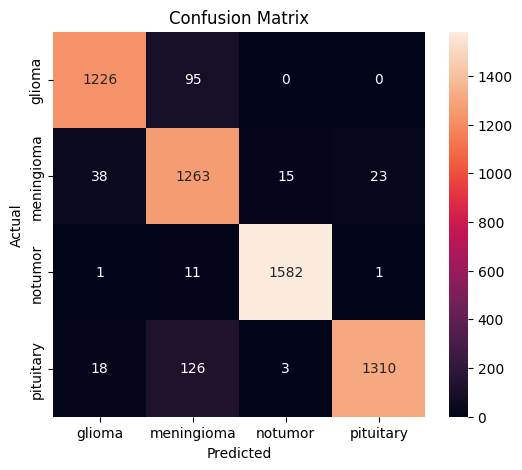

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [28]:
print(classification_report(y, y_pred_classes, target_names=categories))


              precision    recall  f1-score   support

      glioma       0.96      0.93      0.94      1321
  meningioma       0.84      0.94      0.89      1339
     notumor       0.99      0.99      0.99      1595
   pituitary       0.98      0.90      0.94      1457

    accuracy                           0.94      5712
   macro avg       0.94      0.94      0.94      5712
weighted avg       0.95      0.94      0.94      5712



In [46]:
def show_gradcam(img_rgb_input):
    # img_rgb_input is expected to be a resized, RGB image numpy array (e.g., uint8)

    img_norm = img_rgb_input / 255.0
    img_array = np.expand_dims(img_norm, axis=0)

    # EfficientNet last conv layer
    last_conv_layer = "top_conv"

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    heatmap = cv2.resize(heatmap, (224,224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert img_rgb_input to float for addition with heatmap
    superimposed_img = heatmap * 0.4 + img_rgb_input.astype(float)

    plt.figure(figsize=(6,6))
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis("off")
    plt.title("Tumor Attention Region (Grad-CAM)")
    plt.show()


In [49]:
import cv2
import numpy as np

categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

def predict_image(img_path):
    img = cv2.imread(img_path)

    if img is None:
        print("❌ Image load nahi hui")
        return

    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)

    class_index = np.argmax(prediction)
    confidence = np.max(prediction)

    print("Predicted Tumor Type:", categories[class_index])
    print("Confidence:", round(confidence * 100, 2), "%")


In [50]:
img_path = path + "/Testing/glioma/Te-gl_0012.jpg"
predict_image(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
🧠 Predicted Tumor Type: glioma
📊 Confidence: 99.11 %


In [51]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [54]:
def show_gradcam(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (224,224))
    img_array = np.expand_dims(img_resized/255.0, axis=0)

    preds = model.predict(img_array)
    pred_class = np.argmax(preds)

    heatmap = make_gradcam_heatmap(
        img_array,
        model,
        last_conv_layer_name="top_conv"   # Changed from "conv5_block3_out" to "top_conv" for EfficientNetB0
    )

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.title("Original MRI")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Model Focus Area")
    plt.imshow(heatmap_color)
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Final Overlay (Tumor Region)")
    plt.imshow(overlay)
    plt.axis("off")

    print("Predicted:", categories[pred_class])
    print("Confidence:", round(np.max(preds)*100,2), "%")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Predicted: glioma
Confidence: 99.11 %


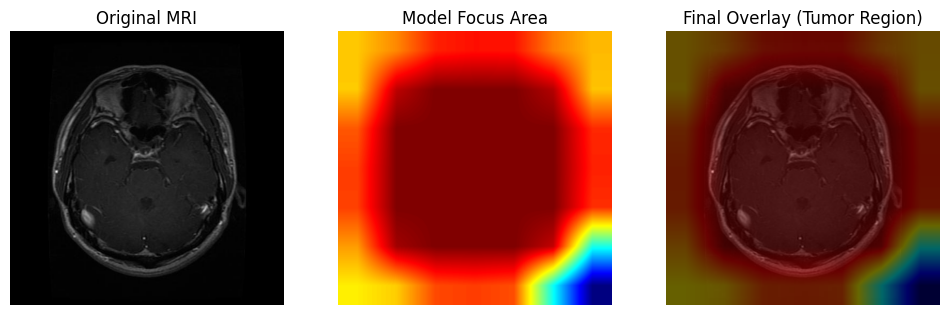

In [55]:
img_path = path + "/Testing/glioma/Te-gl_0012.jpg"
show_gradcam(img_path)
